In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score 

from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering


import json
import folium
import math
import numbers

In [3]:
dataset_raw = pd.read_csv("final_data_real_1.csv")
dataset = dataset_raw.copy()
dataset.drop(columns='Unnamed: 0', inplace=True)

In [56]:
def get_dataframe():
    # 차의수와 퍼센테이지를 입력받는다. 
    hydrogen_car = int(input("Enter the num of hydrogen car : "))
    percentage = int(input("Enter percentage : "))
    percentage /= 100

    # 수소자동차 대수를 기반으로 hybrid 충전소의 개수 K를 구한다. 
    total_charge_needed = 200 * hydrogen_car # 총 필요 충전량
    total_charge_needed -= 190080
    if total_charge_needed <0:
        total_charge_needed = 0

    num_of_hybrid = math.floor(total_charge_needed / 142560) # hybrid 충전소 개수
    num_of_converged = num_of_hybrid # 융복합충전소 개수
    num_of_mobile = 4 * num_of_converged # 이동식 충전소 개수
    
    print("개질기 충전소 개수 : ", num_of_hybrid)
    print("이동식 충전소 개수 : ", num_of_mobile)
    print("원하는 비율 : ", percentage)

In [57]:
get_dataframe()

Enter the num of hydrogen car : 3000
Enter percentage : 4
개질기 충전소 개수 :  2
이동식 충전소 개수 :  8
원하는 비율 :  0.04


In [77]:
def get_dataframe():
    # 차의수와 퍼센테이지를 입력받는다. 
    hydrogen_car = int(input("Enter the num of hydrogen car : "))
    percentage = int(input("Enter percentage : "))
    percentage /= 100

    # 수소자동차 대수를 기반으로 hybrid 충전소의 개수 K를 구한다. 
    total_charge_needed = 200 * hydrogen_car # 총 필요 충전량
    total_charge_needed -= 190080
    if total_charge_needed <0:
        total_charge_needed = 0

    num_of_hybrid = math.floor(total_charge_needed / 142560) # hybrid 충전소 개수
    num_of_converged = num_of_hybrid # 융복합충전소 개수
    num_of_mobile = 4 * num_of_converged # 이동식 충전소 개수
    
    print("개질기 충전소 개수 : ", num_of_hybrid)
    print("이동식 충전소 개수 : ", num_of_mobile)
    print("원하는 비율 : ", percentage)

    temp = dataset.drop_duplicates(subset=['동', '자치구'], keep='first')
    temp.reset_index(inplace=True)
    #temp.drop(columns='Unnamed: 0', inplace=True)
    temp['동별_수소차_비율'] = temp['동별_수소차_대수'] / 146

    # 차의 수와 동별 수소차의 퍼센테이지를 곱한다. 
    temp['동별_수소차_대수'] = temp['동별_수소차_비율'] * hydrogen_car

    # 각 동별 차량의 개수와 퍼센테이지를 곱해 수를 구한다. 
    temp['승용차수_percentage'] = temp['동별_승용차수'] * percentage

    best_row = []

    for i in range(len(temp)):
        if temp['동별_수소차_대수'].iloc[i] >= temp['승용차수_percentage'].iloc[i]:
            best_row.append(temp.iloc[i]['동'])

    # best_row에 속하는 동에 있는 row의 index를 구한다. 
    best_row_index = set()

    for i in range(len(temp)):
        for dong in best_row:
            if temp['동'].iloc[i] == dong:
                best_row_index.add(i)

    # 새로운 copy()인 best_row_sliced를 만들고 best_row의 index값을 drop해준다.
    best_row_sliced = temp.copy()
    for i in best_row_index:
        best_row_sliced.drop(index=i, inplace=True)

    # 계산에 필요한 column을 구해주자.
    columns_to_calculate = ['edu_percent', '동별_친환경자동차수', '합계_사업체수', '㎡당 매매평균가', '가구수별_승용차수', '동별_수소차_대수', '택시']

     # 이제 각 column값들을 표준화시켜주자. 
    for column in columns_to_calculate:
        best_row_sliced[column] = (best_row_sliced[column] - min(best_row_sliced[column])) / (max(best_row_sliced[column]) - min(best_row_sliced[column]))

    #best_row_sliced들 가지고 rank를 구하기 위해 sum_1과 interval의 column을 만든다. 
    # sum_1과 column1에 값을 넣는다. 

    best_row_sliced['sum_1'] = list(range(len(best_row_sliced)))
    best_row_sliced['interval_1'] = list(range(len(best_row_sliced)))

    best_row_sliced['sum_1'] = best_row_sliced['edu_percent'] + best_row_sliced['동별_친환경자동차수'] + best_row_sliced['합계_사업체수'] + best_row_sliced['㎡당 매매평균가'] + best_row_sliced['가구수별_승용차수'] + best_row_sliced['동별_수소차_대수'] + best_row_sliced['택시']
    best_row_sliced['interval_1'] = pd.qcut(best_row_sliced['sum_1'], 10, range(1,11))

    # 원본 dataset에 interval_1의 column을 넣고, 모든 값을 null로 만든 다음 각 best_row_sliced의 값을 interval_1에 넣는다.
    temp['interval_1'] = None
    temp['sum_1'] = best_row_sliced['sum_1']

    for i in range(len(temp)):
        for j in range(len(best_row_sliced)):
            if temp.iloc[i]['동'] == best_row_sliced.iloc[j]['동']:
                temp.loc[i, 'interval_1'] = best_row_sliced.iloc[j]['interval_1']

    # null값에는 가장 높은 값을 준다. 
    for i in range(len(temp)):
        if pd.isna(temp.iloc[i]['interval_1']):
            temp.loc[i, 'interval_1'] = 10

    # 모든 column의 min-max를 구한다. 
    # 이제 각 column값들을 표준화시켜주자. 
    for column in columns_to_calculate:
        temp[column] = (temp[column] - min(temp[column])) / (max(temp[column]) - min(temp[column]))

    for column in columns_to_calculate:
        temp[column] = (temp[column] - min(temp[column])) / (max(temp[column]) - min(temp[column]))

    # sum_2와 interval_2의 coumn을 만든다. 
    temp['sum_2'] = list(range(len(temp)))
    temp['interval_2'] = list(range(len(temp)))    

    # sum_2에는 필요한 값을 다 더하고
    # interval_2에는 값을 나눈다. 
    temp['sum_2'] = temp['edu_percent'] + temp['동별_친환경자동차수'] + temp['합계_사업체수'] + temp['㎡당 매매평균가'] + temp['가구수별_승용차수'] + temp['동별_수소차_대수'] + temp['택시']
    temp['interval_2'] = pd.qcut(temp['sum_2'], 10, range(1,11))

    temp1=temp[['자치구', '동', 'interval_1','sum_1', 'sum_2', 'interval_2']]

    data_result = dataset.merge(temp1, on=['자치구', '동'], how='inner')
    
    data_result.to_csv('{}_hy_{}.csv'.format(hydrogen_car,num_of_hybrid), encoding='cp949')
    return data_result

In [78]:
data_result = get_dataframe()

Enter the num of hydrogen car : 32000
Enter percentage : 4
개질기 충전소 개수 :  43
이동식 충전소 개수 :  172
원하는 비율 :  0.04


data_total_gas_pk = pd.read_csv('data_total_final.csv')

In [79]:
data_total_gas_pk=data_result.copy()

In [97]:
data_total_gas_pk= pd.read_csv('년도별 최종데이터셋/3000_hy_2.csv',encoding='cp949')

In [98]:
data_total_gas_pk[(data_total_gas_pk.업체명 == '대성산업(주)오류동충전소')].iloc[:,14:18]

data_total_gas_pk.iloc[179,14:18]= np.nan

In [99]:
data_total_gas_pk[(data_total_gas_pk.주차장명 == '천호유수지공영주차장')].iloc[:,18:34]

,위도,주차장명,주차장구분,주차장유형,주차구획수,주차급지구분,주차부제시행구분,주차운영요일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,주차요금정보,주차기본시간,주차기본요금,주차경도
64,NaN,천호유수지공영주차장,공영,노외,172.0,4,미시행,평일+토요일+공휴일,00:00,00:00,00:00,00:00,유료,5.0,100.0,127.121876


In [100]:
data_total_gas_pk.iloc[62,18:34] = np.nan
data_total_gas_pk.iloc[63,18:34] = np.nan
data_total_gas_pk.iloc[64,18:34] = np.nan
data_total_gas_pk.iloc[65,18:34] = np.nan
data_total_gas_pk.iloc[455,18:34] = np.nan

In [101]:
data_total_gas_pk[(data_total_gas_pk.수소충전소 == 1 )].자치구.unique()

array(['강남구', '강동구', '강서구', '마포구', '서대문구', '서초구', '영등포구'], dtype=object)

In [102]:
def top_dong(hybrid=2, pk=4):
    final=pd.DataFrame(columns = ['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도',
                                 '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
                                   '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
                                   '주차기본요금', '주차경도', '주차위도'])
    data_gas=data_total_gas_pk[['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도' ]]

    # 수소충전소가 이미 있는 지역은 제외
    indexexist1 = data_gas[(data_gas['동'].isin(data_gas[(data_gas['수소충전소']==1)].동))].index
    data_gas.drop(indexexist1, inplace=True)
    
    # 중복되는 값들 제거
    data_gas.drop_duplicates(subset ="업체명", keep = 'first', inplace=True)
    data_gas.dropna(inplace=True)

    # 중첩분석 8등급 이상인 주유소만 가져오기 
    data_gas=data_gas[(data_gas['interval_1']>7)]
    data_gas.reset_index(drop=True, inplace=True)

    # 거리구하기
    import numbers
    import math

    class GeoUtil:
        @staticmethod
        def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
            """
            유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
            """
            if x1 is None or y1 is None or x2 is None or y2 is None:
                return None
            assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
            assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
            assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
            assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

            dLon = abs(x2-x1) # 경도 차이
            if dLon >= 180:   # 반대편으로 갈 수 있는 경우
                dLon -= 360   # 반대편 각을 구한다
            dLat = y2-y1      # 위도 차이
            return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)
    
    # 거리 2dim넣기
    dist = [[0 for i in range(len(data_gas))] for j in range(len(data_gas))]

    for i in range(len(data_gas)):
        for j in range(len(data_gas)):
            dist[i][j] = GeoUtil.get_euclidean_distance(data_gas.iloc[i,8],data_gas.iloc[i,7],data_gas.iloc[j,8],data_gas.iloc[j,7])
  
    # 군집분석하기
    from sklearn.cluster import AgglomerativeClustering

    cluster = AgglomerativeClustering(n_clusters=hybrid, affinity='euclidean', linkage='single')
    cluster.fit_predict(dist)

    data_gas['sing_clus']=pd.DataFrame(cluster.fit_predict(dist))

    sing_top_dong=data_gas.groupby(['sing_clus','자치구','동','업체명']).agg({'sum_2':'mean','interval_1':'mean'})
    
    sing_index=sing_top_dong.sort_values(by='sum_2', ascending=False).groupby('sing_clus').head(1)
    print(sing_index)
    
    # top 업체명 list 뽑기
    top_lpg = sing_index.index.get_level_values('업체명').tolist()
    top_data = data_gas[(data_gas.업체명.isin(top_lpg))]
    top_data.reset_index(drop=True, inplace=True)
    final=final.append(top_data)
    
    # 지도에 보이기 
    geo_path = "geoData_copy.json"
    geo_str = json.load(open(geo_path, encoding="utf-8"))

    seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
    seoul_map.choropleth(geo_data=geo_str, 
                         data = data_total_gas_pk ,
                         columns=['동', 'interval_1'],
                         fill_color='RdPu',  # GnBu
                         key_on='properties.name',
                         highlight=True,
                         fill_opacity=0.5,
                         line_opacity=1,
                         legend_name="중첩분석")

    # 양재 수소충전소를 찍어보자.
    folium.Marker(
      location=[37.4686275,127.0319203],
      popup='양재 수소 충전소 위치.',
      icon=folium.Icon(color='red',icon='star')
    ).add_to(seoul_map)

    # 상암 수소 충전소를 찍어보자.
    folium.Marker(
      location=[37.5687204,126.8761933],
      popup='상암 수소 충전소 위치.',
      icon=folium.Icon(color='red',icon='star')
    ).add_to(seoul_map)

    # 국회 수소 충전소를 찍어보자.
    folium.Marker(
      location=[37.5311111,126.9132037],
      popup='2019년 완공 예정 국회 수소 충전소 위치.',
      icon=folium.Icon(color='blue',icon='star')
    ).add_to(seoul_map)

    # 강동구 상일충전소를 찍어보자.
    folium.Marker(
      location=[37.5392486,127.128611],
      popup='2019년 완공 예정 강동구 상일충전소 위치',
      icon=folium.Icon(color='blue',icon='star')
    ).add_to(seoul_map)

    # 추천 lpg 주유소 보이기
    for i in range(len(top_data)):
        folium.Marker(
            location=top_data.loc[i,['경도','위도']],
            popup=top_data.loc[i,['업체명']],
            icon=folium.Icon(color='lightgray',icon='home')
        ).add_to(seoul_map)
    seoul_map
   
    ##################################################  
    # 주차장 데이터 합치기
    data_parking=data_total_gas_pk[[ '자치구', '동', 'sum_2', 'interval_1',  '수소충전소',
                       '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
           '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
           '주차기본요금', '주차경도', '주차위도' ]]

    # 수소 충전소 있는 애들 빼기
    indexexist2 = data_parking[(data_parking['동'].isin(data_parking[(data_parking['수소충전소']==1)].동))].index
    data_parking.drop(indexexist2, inplace=True)

    # 수소 충전소 개질기 추천된 애들 빼기
    data_parking = data_parking[~(data_parking.동.isin(top_data.동))]
    
    # 중복되는 애들 빼기 
    data_parking.drop_duplicates(subset ="주차장명", keep = 'first', inplace=True)
    data_parking.dropna(inplace=True)

    # 중첩 8등급 이상인 애들만 가져오기
    data_parking = data_parking[(data_parking.interval_1>7)]
    data_parking.reset_index(drop=True, inplace=True)
    
    # 개질기 와의 거리 군집
    top_data.reset_index(drop=True, inplace=True)
    data_parking.reset_index(drop=True, inplace=True)
    
    dist2 = [[0 for i in range(len(data_parking))] for j in range(len(top_data))]

    for i in range(len(top_data)):
        for j in range(len(data_parking)):
            dist2[i][j] = GeoUtil.get_euclidean_distance(top_data.loc[i,'위도'],top_data.loc[i,'경도'],data_parking.loc[j,'주차경도'],data_parking.loc[j,'주차위도'])

    dis= pd.DataFrame(dist2).T

    # 군집구하기 
    from sklearn.cluster import AgglomerativeClustering

    cluster2 = AgglomerativeClustering(n_clusters=hybrid * pk, affinity='euclidean', linkage='average')
    cluster2.fit_predict(dis)

    data_parking['avg_clus']=pd.DataFrame(cluster2.fit_predict(dis))

    comp_top_parking=data_parking.groupby(['avg_clus','자치구','동','주차장명']).agg({'sum_2':'mean','interval_1':'mean'})

    comp_index=comp_top_parking.sort_values(by='sum_2', ascending=False).groupby('avg_clus').head(1)
    print(comp_index)
    
    # top 주차장 애들 뽑기
    top_pk_index = comp_index.index.get_level_values('주차장명').tolist()

    top_parking = data_parking[(data_parking.주차장명.isin(top_pk_index))]
    top_parking.reset_index(drop=True, inplace=True)
    final=final.append(top_parking)
    
    # 데이터 주차장 데이터셋 저장
    final.to_csv('final_list_{}.csv'.format(hybrid), encoding='cp949')

    # 지도에 나타내기
    for i in range(len(top_parking)):
        folium.Marker(
            location=top_parking.loc[i,['주차위도','주차경도']],
            popup=top_parking.loc[i,['주차장명']],
            icon=folium.Icon(color='gray')
        ).add_to(seoul_map)

    seoul_map.save("seoul_map_{}.html".format(hybrid))
    seoul_map

In [104]:
top_dong(2,4)

                                  sum_2  interval_1
sing_clus 자치구 동    업체명                             
1         강남구 세곡동  강남복지충전소     4.515051          10
0         강서구 화곡1동 대흥에너지산업(주)  2.785943          10
                                       sum_2  interval_1
avg_clus 자치구  동    주차장명                                 
3        강남구  역삼1동 도곡로21길7          4.999510          10
2        서초구  잠원동  잠원동 방음언덕형 공영주차장  3.868664          10
1        강남구  일원본동 일원역              3.345667          10
5        강서구  우장산동 화곡5-2            2.571027           9
6        영등포구 문래동  문래동 공영주차장        2.570135           9
0        동작구  대방동  대방생태             2.477951           9
7        강서구  공항동  공항동(송정역)         2.024792           8
4        강동구  암사1동 암사1동공영주차장        1.985213           8


# 노선 추천 

# WARD 군집분석
-   ward : 기본값인 ward 연결은 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합친다. 그래서 크기가 비교적 비슷한 클러스터가 만들어진다.


# kneighbors_graph를 이용한 군집분석


In [1230]:
def line_rec(data='final_list_16',connec=2,pk=64,lpg=16):    
    list16 = pd.read_csv('년도별 뽑은 주차장,lpg/{}.csv'.format(data),encoding='cp949')

    # 거리구하기
    import numbers
    import math

    class GeoUtil:
        @staticmethod
        def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
            """
            유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
            """
            if x1 is None or y1 is None or x2 is None or y2 is None:
                return None
            assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
            assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
            assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
            assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

            dLon = abs(x2-x1) # 경도 차이
            if dLon >= 180:   # 반대편으로 갈 수 있는 경우
                dLon -= 360   # 반대편 각을 구한다
            dLat = y2-y1      # 위도 차이
            return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

    data_gas=list16[['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도' ]]
    data_gas.dropna(inplace=True)

    data_parking=list16[[ '자치구', '동', 'sum_2', 'interval_1',  '수소충전소',
                       '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
           '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
           '주차기본요금', '주차경도', '주차위도' ]]
    data_parking.dropna(inplace=True)

    # 개질기 와의 거리 군집
    data_gas.reset_index(drop=True, inplace=True)
    data_parking.reset_index(drop=True, inplace=True)

    dist = [[0 for i in range(len(data_parking))] for j in range(len(data_gas))]

    for i in range(len(data_gas)):
        for j in range(len(data_parking)):
            dist[i][j] = GeoUtil.get_euclidean_distance(data_gas.loc[i,'위도'],data_gas.loc[i,'경도'],data_parking.loc[j,'주차경도'],data_parking.loc[j,'주차위도'])

    dis= pd.DataFrame(dist).T
    dis1 = pd.DataFrame(dist)

    # kneighbors_graph를 이용한 군집분석

    # WARD 군집분석
#     ward : 기본값인 ward 연결은 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합친다. 그래서 크기가 비교적 비슷한 클러스터가 만들어진다.

    # parking 군집분석

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph

    connectivity = kneighbors_graph(dis, connec, mode='connectivity', include_self=True)
    ward = AgglomerativeClustering(n_clusters=pk, connectivity=connectivity,linkage='ward').fit(dis)

    data_parking['ward_clus']=pd.DataFrame(ward.fit_predict(dis))

    ward_top_parking=data_parking.groupby(['ward_clus','자치구','동','주차장명']).agg({'sum_2':'mean','interval_1':'mean'})

    ward_top_parking.reset_index(inplace=True)

    ward_top_parking['group']=0

    # 같은 그룹 번호 매기기 
    ward_top_parking.loc[::1,'group']=ward_top_parking.loc[::1,'group'].rank(method='first')
    # ward_top_parking.loc[1::2,'group']=ward_top_parking.loc[1::2,'group'].rank(method='first')

    ward_top_parking = ward_top_parking[['group','자치구','동','주차장명']]

    ward_top_parking=ward_top_parking.merge(data_parking, on = ['자치구','주차장명','동'], how='left')

    # lpg 군집분석

    # connectivity = kneighbors_graph(dis1, 1, mode='connectivity', include_self=True)
    ward2 = AgglomerativeClustering(n_clusters=lpg, linkage='ward').fit(dis1)

    data_gas['ward_clus']=pd.DataFrame(ward2.fit_predict(dis1))

    ward_top_gas=data_gas.groupby(['ward_clus','자치구','동','업체명']).agg({'sum_2':'mean','interval_1':'mean'})

    ward_top_gas.reset_index(inplace=True)

    ward_top_gas=ward_top_gas[['ward_clus','자치구','동','업체명']]

    # lpg, 주차장 연결하기

    ward_top_gas=ward_top_gas.merge(data_gas, on=['ward_clus','자치구','동','업체명'],how='left')

    ward_top_gas['ward_clus']+=1

    # 같은 그룹 번호 매기기 
    for i in range(4):
        ward_top_parking.loc[i::4,'ward_clus']=ward_top_parking.loc[i::4,'ward_clus'].rank(method='first')

    line16_total=ward_top_gas.merge(ward_top_parking, on=['ward_clus'],how='outer')

    line16_total=line16_total[['ward_clus', '업체명','경도', '위도','주차장명', '주차경도', '주차위도','group' ,'sum_2_y']]
    
    line16_total.to_csv('location_{}.csv'.format(data), encoding='cp949')
    
    line16_list=line16_total[['ward_clus', '주차경도', '주차위도']]

    line16_list.columns=['ward_clus', '주차위도', '주차경도']

    line16_list=line16_list.set_index('ward_clus')

    a=[]
    for i in line16_list.index.unique():
        a+=[line16_list.loc[i,:].values.tolist()]

    line16_lpg=line16_total[['ward_clus', '위도', '경도']]

    line16_lpg=line16_lpg.set_index('ward_clus')

    line16_lpg.drop_duplicates(subset='경도', keep='first', inplace=True)

    b=[]
    for i in line16_lpg.index:
        b+=[[line16_lpg.loc[i,:].values.tolist()]]

    c=[]
    for i in range(len(a)):
        c+=[b[i]+a[i]]
    print(c)
    pd.DataFrame(c).to_excel('line_{}.xlsx'.format(data), header=False, index=False)
    
    d=[]
    for i in range(len(c)):
        for j in range(1,5):
            d+=[GeoUtil.get_euclidean_distance(c[i][0][0],c[i][0][1],c[i][j][0],c[i][j][1])]

    d=pd.DataFrame(d)

    d['group']=0

    d.columns=['dist','group']
    
    for i in range(4):
        d.loc[i::4,'group']=d.loc[i::4,'group'].rank(method='first')
        
    
    print(d.groupby('group').dist.mean())
    print('mean :',d.groupby('group').dist.mean().mean())
    print('sum :', d.groupby('group').dist.mean().sum())

In [1257]:
line_rec(data='final_list_16',connec=2 ,pk=64 ,lpg=16)

[[[126.9190242, 37.6436336], [127.014296, 37.562026], [126.98358586270001, 37.5736815664], [126.9565401309, 37.612215534899995], [126.920786, 37.586576]], [[126.8991679, 37.5777045], [126.994045, 37.574496], [126.906839, 37.59231079999999], [126.915337, 37.626498], [126.915289, 37.593506]], [[126.88625829999998, 37.5174334], [126.89481, 37.499611], [126.923549, 37.624469], [126.914663, 37.517666], [126.908556, 37.523736]], [[126.8450293, 37.52972379999999], [126.91133700000002, 37.50262100000001], [126.861236, 37.516217], [126.909151, 37.514358], [126.899427, 37.523768]], [[126.9932777, 37.4730658], [126.96228700000002, 37.506417], [126.885352, 37.536396], [126.8947892, 37.4648929], [126.849601, 37.516131]], [[127.12940829999998, 37.5061584], [127.020988, 37.504727], [126.865111, 37.5419998], [127.0003038, 37.497432], [126.980263, 37.505942]], [[127.0096661, 37.5188926], [126.869307, 37.522152], [126.918608, 37.510226], [127.124748, 37.485972], [127.097721, 37.508941]], [[126.766738, 3

# 일반군집분석

# parking 군집분석

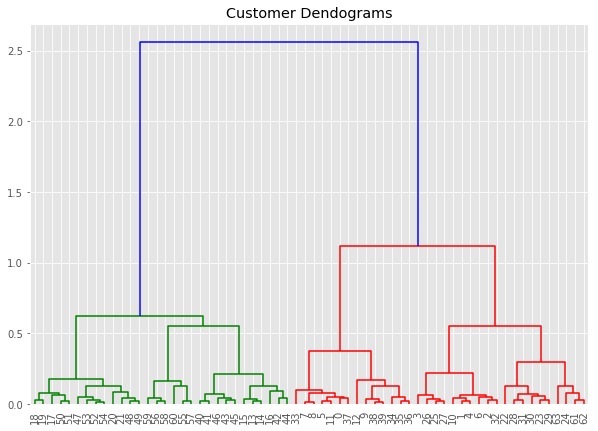

In [1133]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dis, method='ward'), leaf_font_size=10)

In [1134]:
## 군집구하기 
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters=64, affinity='euclidean', linkage='ward')
cluster2.fit_predict(dis)

array([36, 52, 47, 59, 39, 57, 33, 62, 61, 41, 37, 38, 48, 58, 54, 43, 42,
       55, 46, 45, 44, 40, 34, 23, 49, 56, 20, 18, 22, 63, 30, 28, 35, 19,
       32, 53, 50, 26, 31, 51, 60, 21,  9, 24, 27, 16, 17, 15, 25, 12, 29,
       10, 14, 11,  4, 13,  5,  8,  7,  3,  6,  1,  2,  0], dtype=int64)

In [1135]:
data_parking['ward_clus']=pd.DataFrame(cluster2.fit_predict(dis))

ward_top_parking=data_parking.groupby(['ward_clus','자치구','동','주차장명']).agg({'sum_2':'mean','interval_1':'mean'})

In [1136]:
ward_top_parking.reset_index(inplace=True)

In [1137]:
ward_top_parking['group']=0

In [1139]:
# 같은 그룹 번호 매기기 
ward_top_parking.loc[::1,'group']=ward_top_parking.loc[::1,'group'].rank(method='first')
# ward_top_parking.loc[1::2,'group']=ward_top_parking.loc[1::2,'group'].rank(method='first')

In [1140]:
ward_top_parking = ward_top_parking[['group','자치구','동','주차장명']]

In [1141]:
ward_top_parking=ward_top_parking.merge(data_parking, on = ['자치구','주차장명','동'], how='left')

# lpg 군집분석

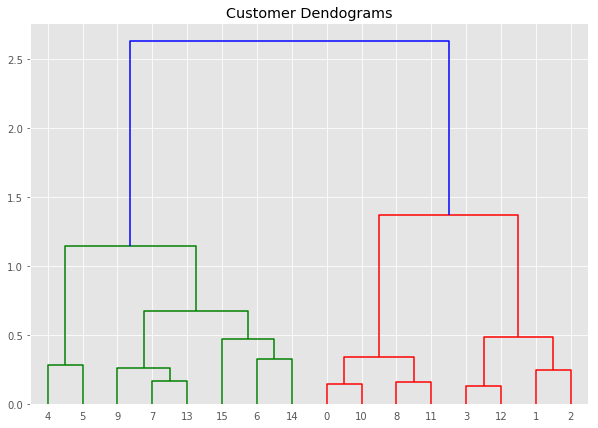

In [1142]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dis1, method='ward'), leaf_font_size=10)

In [1143]:
## 군집구하기 
from sklearn.cluster import AgglomerativeClustering

cluster3 = AgglomerativeClustering(n_clusters=16, affinity='euclidean', linkage='ward')
cluster3.fit_predict(dis1)

array([14, 11,  8, 15,  9,  7,  3, 12, 13, 10,  6,  4,  5,  2,  1,  0],
      dtype=int64)

In [1144]:
data_gas['ward_clus']=pd.DataFrame(cluster3.fit_predict(dis1))

ward_top_gas=data_gas.groupby(['ward_clus','자치구','동','업체명']).agg({'sum_2':'mean','interval_1':'mean'})

In [1145]:
ward_top_gas.reset_index(inplace=True)

In [1146]:
ward_top_gas=ward_top_gas[['ward_clus','자치구','동','업체명']]

# lpg, 주차장 연결하기

In [1147]:
ward_top_gas=ward_top_gas.merge(data_gas, on=['ward_clus','자치구','동','업체명'],how='left')

In [1148]:
ward_top_gas['ward_clus']+=1

In [1149]:
# 같은 그룹 번호 매기기 
for i in range(4):
    ward_top_parking.loc[i::4,'ward_clus']=ward_top_parking.loc[i::4,'ward_clus'].rank(method='first')

In [1150]:
line16_total=ward_top_gas.merge(ward_top_parking, on=['ward_clus'],how='outer')

In [1151]:
line16_total=line16_total[['ward_clus', '업체명','경도', '위도','주차장명', '주차경도', '주차위도','group' ,'sum_2_y']]

In [1152]:
line16_list=line16_total[['ward_clus', '주차경도', '주차위도']]

In [1153]:
line16_list.columns=['ward_clus', '주차위도', '주차경도']

In [1154]:
line16_list=line16_list.set_index('ward_clus')

In [1155]:
a=[]
for i in line16_list.index.unique():
    a+=[line16_list.loc[i,:].values.tolist()]

In [1156]:
line16_lpg=line16_total[['ward_clus', '위도', '경도']]

In [1157]:
line16_lpg=line16_lpg.set_index('ward_clus')

In [1158]:
line16_lpg.drop_duplicates(subset='경도', keep='first', inplace=True)

In [1159]:
b=[]
for i in line16_lpg.index:
    b+=[[line16_lpg.loc[i,:].values.tolist()]]

In [1160]:
c=[]
for i in range(len(a)):
    c+=[b[i]+a[i]]

In [1161]:
d=[]
for i in range(len(c)):
    for j in range(1,5):
        d+=[GeoUtil.get_euclidean_distance(c[i][0][0],c[i][0][1],c[i][j][0],c[i][j][1])]

In [1162]:
d=pd.DataFrame(d)

In [1163]:
d['group']=0

In [1164]:
d.columns=['dist','group']

In [1165]:
for i in range(4):
    d.loc[i::4,'group']=d.loc[i::4,'group'].rank(method='first')

In [1247]:
d.groupby('group').dist.mean().sum()

1.9525675

# 서울 전체에 있는 주유소와 주차장 

In [375]:
data_gas=data_total_gas_pk[['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도' ]]
# 중복되는 값들 제거
data_gas.drop_duplicates(subset ="업체명", keep = 'first', inplace=True)
data_gas.dropna(inplace=True)
data_gas.reset_index(drop=True, inplace=True)

In [379]:
data_parking=data_total_gas_pk[[ '자치구', '동', 'sum_2', 'interval_1',  '수소충전소',
                   '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
       '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
       '주차기본요금', '주차경도', '주차위도' ]]

# 중복되는 애들 빼기 
data_parking.drop_duplicates(subset ="주차장명", keep = 'first', inplace=True)
data_parking.dropna(inplace=True)
data_parking.reset_index(drop=True, inplace=True)

In [380]:
# 지도에 보이기 
geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_gas_pk ,
                     columns=['동', 'interval_1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="중첩분석")

# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 추천 lpg 주유소 보이기
for i in range(len(data_gas)):
    folium.Marker(
        location=data_gas.loc[i,['경도','위도']],
        popup=data_gas.loc[i,['업체명']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)
    seoul_map
    
# 주차장에 나타내기
for i in range(len(data_parking)):
    folium.Marker(
        location=data_parking.loc[i,['주차위도','주차경도']],
        popup=data_parking.loc[i,['주차장명']],
        icon=folium.Icon(color='gray')
    ).add_to(seoul_map)

In [381]:
seoul_map